In [1]:
import numpy as np
import seaborn
import matplotlib.pyplot as plt
import tensorflow as tf
from functools import reduce

%matplotlib inline

GLOBAL_SEED=1
VERBOSITY=1
TESTING=0

np.random.seed(GLOBAL_SEED)

In [2]:
# useful function for recovering functions in deleted cells
def rescue_code(function):
    import inspect
    get_ipython().set_next_input("".join(inspect.getsourcelines(function)[0]))

In [3]:
# wrapper around tf.get_variable that checks if the variable has already been defined.
# useful for playing around in jupyter. allows you to call cells multiple times
def get_variable_wrap(*args, **kwargs):
    try:
        return tf.get_variable(*args, **kwargs)
    except ValueError:
        tf.get_variable_scope().reuse_variables()
        return tf.get_variable(*args, **kwargs)

## do matrix multiplication with weights and add bias (as in fully connected layer)
def fc_act(x, next_layer_size, act=None, name="fc"):
    nbatches = x.get_shape()[0]
    prev_layer_size = x.get_shape()[1]
    with tf.name_scope("fc"):
        w = get_variable_wrap("weights", [prev_layer_size, next_layer_size], dtype=tf.float32, initializer=tf.random_normal_initializer())
        b = get_variable_wrap("bias", [next_layer_size], dtype=tf.float32, initializer=tf.constant_initializer(0.1))
        o = tf.add(tf.matmul(x, w), b)
        if act: return act(o)
        else: return o

# Sample Data
I want to create 100 bi-variate time-series sampled from the same distribution and split them into train/validation/test 70/20/10, i.e. split into groups of time-series size 14/4/2.

In [4]:
def gen_time_series(n_points):
    time_series = np.array([[np.random.normal(mu*i, sigma*i), 
                        np.random.normal(mu*i, sigma*i/4)] 
                       for i in range(n_points)])
    return time_series

(100, 100, 2)
20000 data values


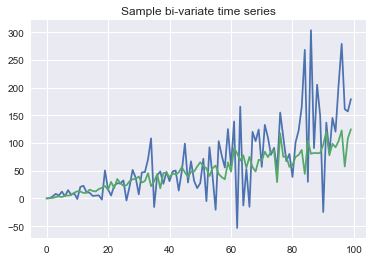

In [5]:
mu=1
sigma=1
n_series=100
n_points = 100
n_features = 2
# multi-variate time-series: 
# x_t ~ [Gaussian(mu*t,sigma*t), Gaussian(mu*t,sigma*t/4)]
# Points X Time X Features
x_data = np.zeros((n_series,n_points,n_features), dtype=np.float32)
for i in range(n_series):
    x_data[i] = gen_time_series(n_points)

if TESTING: x_data_test=x_data[:10]
plt.title("Sample bi-variate time series")
for i in range(n_features):
    plt.plot(x_data[0,:,i]);
print(x_data.shape)
print(reduce(lambda x,y: x*y, list(x_data.shape)), "data values")

x_train = x_data[:70]
x_validate = x_data[70:90]
x_test = x_data[-10:]

# Building Variational RNN

note that all gaussian distribtutions: p(z), q(z|x), p(x|z) should have the same dimensionality, i.e. share z_size

In [6]:
# First I'm going to define the loss functions necessary because they don't depend on anything
def negative_log_likelihood_gaussian(y, mu, sigma):
    """
                a                  b              c
    (1/2)*[ ((y-mu)/sigma)^2 + 2*log(sigma) + log(2*pi) ]
    learn more: https://www.statlect.com/fundamentals-of-statistics/normal-distribution-maximum-likelihood
    """
#     sigma might be really small. in that case, a & b blow up
    sigma=tf.clip_by_value(sigma, 1e-3,1e10)
    a = tf.square(tf.div(tf.subtract(y,mu), sigma))
    b = 2*tf.log(sigma)
    c = tf.log(2*np.pi)
    return tf.add(tf.add(a,b),c)

def kl_gaussian_gaussian(mu1, sigma1, mu2, sigma2):
    """
            a                  b         c           d
    log(sigma2/sigma1) + (sigma1^2 + (mu1-mu2)^2)/2sigma2^2 - 1/2
    """
    # Note: if sigma1 or sigma2 go to 0, this explodes
    sigma1=tf.clip_by_value(sigma1, 1e-3,1e10)
    sigma2=tf.clip_by_value(sigma2,1e-3,1e10)
    a = tf.log(tf.divide(sigma2,sigma1))
    b = tf.square(sigma1)
    c = tf.square(tf.subtract(mu1,mu2))
    d = 2*tf.square(sigma2)
    e = tf.divide(tf.add(b,c), d)
    return tf.add(a,e) - 0.5

# I will also define a simple wrapper around reshape to flatten the 1st two dimensions of a tensor
def flatten(x):
    return tf.reshape(x, [int(x.shape[0])*int(x.shape[1]), -1])

def tf_sample(batch_size, layer_size, mu, sigma):
    epsilon = tf.random_normal(shape=[batch_size, layer_size], seed=GLOBAL_SEED)
    return tf.add(mu, tf.multiply(epsilon, sigma))


In [7]:
class VRNN(object):
    """class for VRNN."""
    def __init__(self, input_shape, rnn_size, x_size, x_1_size, 
               z_size, z_1_size, phi_size, prior_size, theta_size, lr=.01):
        self.batch_size = input_shape[0]
        self.ntime_steps = input_shape[1]
        self.nfeatures = input_shape[2]
        
        self.rnn_size = rnn_size
        self.x_size = x_size
        self.x_1_size = x_1_size
        self.z_size = z_size
        self.z_1_size = z_1_size
        self.phi_size = phi_size
        self.prior_size = prior_size
        self.theta_size = theta_size
        self.learning_rate=lr
        
        self.inputs = self._define_input_placeholder(input_shape)
        self._build()

    def _define_input_placeholder(self, input_shape):
        return tf.placeholder(tf.float32, shape=input_shape, name="x_t")

    def _tensorboard_additions(self):
        # get latest values from VRNN so that you can visualize how the last time-step changes over time

        with tf.name_scope("prior_sample"):
            prior_mu, prior_sigma = self.priors;
            prior_t = tf_sample(self.batch_size, self.z_size, prior_mu[:,-1], prior_sigma[:,-1])
            tf.summary.histogram("prior_t", prior_t) # should be a unit gaussian
        
        with tf.name_scope("z_sample"):
            z_t = self.calculated_posteriors;
            z_t = z_t[:,-1]
            tf.summary.histogram("z_t", z_t)

        with tf.name_scope("x_sample"):
            x_mu, x_sigma = self.likelihoods;
            x_t = tf_sample(self.batch_size, self.x_size, x_mu[:,-1], x_sigma[:,-1])
            tf.summary.histogram("x_t", x_t)
        
        
    def _build(self):
        self._init_cell()
        # transpose input so T X N X F instead of N X T X F
        # this allows you to do one time-step at a time for all batches in tf.scan
        self.inputs_t = tf.transpose(self.inputs, [1, 0, 2])
        self.outputs = self._scan_sequence(self.inputs_t)   

        self._tensorboard_additions()

        with tf.name_scope("negative-log-likelihood"):
            self.nll = negative_log_likelihood_gaussian(self.inputs_t, 
                                                        self.outputs[-2], self.outputs[-1])
            self.nll_r = flatten(self.nll)
        with tf.name_scope("kl-Divergence"):
            self.klgg = kl_gaussian_gaussian(self.outputs[5], self.outputs[6], 
                                             self.outputs[8], self.outputs[9])
            self.klgg_r = flatten(self.klgg)

        with tf.name_scope("objective-function"):
            nll_mean=tf.reduce_mean(self.nll_r)
            klgg_mean=tf.reduce_mean(self.klgg_r)
            self.objective = tf.add(tf.reduce_mean(self.nll_r),tf.reduce_mean(self.klgg_r))
            
            tf.summary.scalar("negative_log-likelihood", nll_mean)
            tf.summary.scalar("KL_divergence", klgg_mean)
            tf.summary.scalar("ELBO", self.objective)
        
        with tf.name_scope("train"):
            self.train_step = tf.train.AdamOptimizer(self.learning_rate).minimize(self.objective)

    def _init_cell(self):
        with tf.variable_scope("lstm"):
            try:
                self.cell = tf.contrib.rnn.LSTMCell(rnn_size, state_is_tuple=True)
            except:
                self.cell = tf.contrib.rnn.LSTMCell(rnn_size, state_is_tuple=True, reuse=True)
        self.state = self.cell.zero_state(batch_size, tf.float32)
    
    def _calculate_prior(self, hidden_state):
        """
        calculate your prior based on your previous state information, i.e. z ~ p(z)
        """
        with tf.variable_scope("prior"):
            prior = fc_act(hidden_state, prior_size, act=tf.nn.relu, name="fc_prior")
        with tf.variable_scope("prior_mu"):
            prior_mu = fc_act(prior, z_size, name="fc_prior_mu")
        with tf.variable_scope("prior_sigma"):
            prior_sigma = fc_act(prior, z_size, act=tf.nn.softplus, name="fc_prior_sigma")
        return [prior, 
                prior_mu, 
                prior_sigma]
        
    def _encode_x(self, x_t, hidden_state):
        """
        infer the latent values given z, i.e. z ~ p(z|x)
        """
        with tf.variable_scope("x_1"):
            x_1 = fc_act(x_t, self.x_1_size, act=tf.nn.relu, name="fc_x_1")
        with tf.variable_scope("phi"):
            phi = fc_act(tf.concat([x_1, hidden_state], axis=1), self.phi_size, act=tf.nn.relu, name="fc_phi")
        with tf.variable_scope("phi_mu"):
            phi_mu = fc_act(phi, self.z_size, name="fc_phi_mu")
        with tf.variable_scope("phi_sigma"):
            phi_sigma = fc_act(phi, self.z_size, act=tf.nn.softplus, name="fc_phi_sigma")
        epsilon = tf.random_normal(shape=[x_t.get_shape().as_list()[0], self.z_size], seed=GLOBAL_SEED)
        # z = mu + epsilon*sigma
        z_t = tf.add(phi_mu, tf.multiply(epsilon, phi_sigma))
        return [x_1, 
                phi,
                phi_mu,
                phi_sigma,
                z_t]
    
    def _decode_z(self, z_t, hidden_state):
        """
        generate the mean and variance for your data from latent values z, i.e. x ~ q(x|z)
        """
        with tf.variable_scope("z_1"):
            z_1 = fc_act(z_t, self.z_1_size, act=tf.nn.relu, name="fc_z_1")
        with tf.variable_scope("theta"):
            theta = fc_act(tf.concat([z_1, hidden_state],axis=1), self.theta_size, act=tf.nn.relu, name="fc_theta")
        with tf.variable_scope("theta_mu"):
            theta_mu = fc_act(theta, self.x_size, name="fc_theta_mu")
        with tf.variable_scope("theta_sigma"):
            theta_sigma = fc_act(theta, self.x_size, act=tf.nn.softplus, name="fc_theta_sigma")
        
        return [z_1,
                theta,
                theta_mu,
                theta_sigma]
    def _rnn_recurrence(self, x_1, z_1, cell_state, hidden_state):
        """
        use x_1 and z_1 and the previous hidden state to update lstm cell
        """
        try:
            return self.cell(tf.concat([x_1, z_1], axis=1), [cell_state, hidden_state], "rnn")
        except:
            tf.get_variable_scope().reuse_variables()
            return self.cell(tf.concat([x_1, z_1], axis=1), [cell_state, hidden_state], "rnn")

        
    def _vrnn_step(self, vals, x_t):
        """
        A single step on the time-series (or batch) using the VRNN. 
        """
        # I chose to store them all but you don't HAVE to do this. 
        # This is a convenient thing to do however so you can check values later on

        prev_hidden = vals[1]
        # mu_z, sigma_z = f(x, ht-1)
        encoding_vals = [x_1, 
                phi,
                phi_mu,
                phi_sigma,
                z_t] = \
                    self._encode_x(x_t, prev_hidden)
        
        # mu_phi, sigma_phi = f(ht-1)
        prior_vals = [prior, 
                prior_mu, 
                prior_sigma] = \
                    self._calculate_prior(prev_hidden)

        # mu_x , sigma_x = f(z, ht-1)
        decoding_vals = [z_1,
                theta,
                theta_mu,
                theta_sigma] = \
                    self._decode_z(z_t, prev_hidden)
            
        output, state = self._rnn_recurrence(x_1, z_1, vals[0], vals[1])

        return [
            state[0], # vals[0],
            state[1], # vals[1],
            output, # vals[2],
            x_1, # vals[3],
            phi, # vals[4],
            phi_mu, # vals[5],
            phi_sigma, # vals[6],
            prior, # vals[7],
            prior_mu, # vals[8],
            prior_sigma, # vals[9],
            z_t, # vals[10],
            z_1, # vals[11],
            theta, # vals[12],
            theta_mu, # vals[13],
            theta_sigma # vals[14]
        ]
   
    def _scan_sequence(self, sequence):
        with tf.name_scope("scan_input"):
            return tf.scan(self._vrnn_step, sequence, initializer=[
                    self.state[0], # cell_state - 0,
                    self.state[1], # hidden_state - 1,
                    tf.Variable(np.zeros((self.batch_size, self.rnn_size), dtype=np.float32)), # cell_output - 2
                    tf.Variable(np.zeros((self.batch_size, self.x_size), dtype=np.float32)), # x_1 - 3
                    tf.Variable(np.zeros((self.batch_size, self.phi_size), dtype=np.float32)), # phi - 4
                    tf.Variable(np.zeros((self.batch_size, self.z_size), dtype=np.float32)), # phi_mu - 5
                    tf.Variable(np.zeros((self.batch_size, self.z_size), dtype=np.float32)), # phi_sigma - 6
                    tf.Variable(np.zeros((self.batch_size, self.prior_size), dtype=np.float32)), # prior - 7
                    tf.Variable(np.zeros((self.batch_size, self.z_size), dtype=np.float32)), # prior_mu - 8
                    tf.Variable(np.zeros((self.batch_size, self.z_size), dtype=np.float32)), # prior_sigma - 9
                    tf.Variable(np.zeros((self.batch_size, self.z_size), dtype=np.float32)), # z_t - 10
                    tf.Variable(np.zeros((self.batch_size, self.z_size), dtype=np.float32)), # z_1 - 11
                    tf.Variable(np.zeros((self.batch_size, self.theta_size), dtype=np.float32)), # theta - 12
                    tf.Variable(np.zeros((self.batch_size, self.x_size), dtype=np.float32)), # theta_mu - 13
                    tf.Variable(np.zeros((self.batch_size, self.x_size), dtype=np.float32)) # theta_sigma - 14
            ])
    
    @property
    def loss(self): return self.objective
    
    @property
    def x(self): return self.inputs
    
    @property
    def optimization_step(self): return self.train_step

    @property
    def cell_states(self): 
        return tf.transpose(self.outputs[0], [1, 0, 2])
        
    @property
    def hidden_states(self): 
        return tf.transpose(self.outputs[1], [1, 0, 2])

    @property
    def priors(self): 
        """
        mean and variance for prior on z p(z)
        transposed from T X N X F to be N X T X F
        """
        return tf.transpose(self.outputs[8], [1, 0, 2]), tf.transpose(self.outputs[9], [1, 0, 2])

    @property
    def calculated_posteriors(self): 
        """
        mean and variance to infer z from q(z|x)
        transposed from T X N X F to be N X T X F
        """
        return tf.transpose(self.outputs[10], [1, 0, 2])
    
    @property
    def posteriors(self): 
        """
        mean and variance to infer z from q(z|x)
        transposed from T X N X F to be N X T X F
        """
        return tf.transpose(self.outputs[5], [1, 0, 2]), tf.transpose(self.outputs[6], [1, 0, 2])

    @property
    def likelihoods(self): 
        """
        mean and variance to reconstruct x from p(x|z)
        transposed from T X N X F to be N X T X F
        """
        return tf.transpose(self.outputs[-2], [1, 0, 2]), tf.transpose(self.outputs[-1], [1, 0, 2])

In [8]:
# test computing latent variable
batch_size=10

rnn_size=20
x_size=x_data.shape[2]
x_1_size=x_data.shape[2]

z_size=15
z_1_size=15

phi_size = 25   # N ~ q(z|x)
prior_size = 25 # N ~ p(z)
theta_size = 25 # N ~ p(x|z)

tf.reset_default_graph()
vrnn = VRNN([batch_size, n_points, n_features], rnn_size, x_size, x_1_size, 
       z_size, z_1_size, phi_size, prior_size, theta_size)    

In [9]:
# define session and model saver
def get_new_session():
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    return sess
sess = get_new_session()

In [10]:
import os
import os.path
import shutil
LOGDIR = "/tmp/test1/"
if os.path.exists(LOGDIR):
    shutil.rmtree(LOGDIR)
merged_summary = tf.summary.merge_all()

writer = tf.summary.FileWriter(LOGDIR)
writer.add_graph(sess.graph)


# Train

In [15]:
def train(sess, data, model, summaries, writer, batch_size, run, tensor_freq=10):
    i=0
    nbatches=max(data.shape[0]//batch_size,1)
    print(run, )
    for j in range(nbatches):
        batch = x_data[j*batch_size:(j+1)*batch_size]
        if i % tensor_freq == 0:
            s = sess.run(summaries, feed_dict={model.x: batch})
            writer.add_summary(s, run*nbatches+i)
        sess.run(model.optimization_step, feed_dict={model.x: batch})
        i += 1


In [16]:
for i in range(2000):
    train(sess, x_train, vrnn, merged_summary, writer, batch_size, run=i, tensor_freq=10)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999


In [23]:
for i in range(2000,4000):
    train(sess, x_train, vrnn, merged_summary, writer, batch_size, run=i, tensor_freq=10)

2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102
2103
2104
2105
2106
2107
2108
2109
2110
2111
2112
2113
2114
2115
2116
2117
2118
2119
2120
2121
2122
2123
2124
2125
2126
2127
2128
2129
2130
2131
2132
2133
2134
2135
2136
2137
2138
2139
2140
2141
2142
2143
2144
2145
2146
2147
2148
2149
2150
2151
2152
2153
2154
2155
2156
2157
2158
2159
2160
2161
2162
2163
2164
2165
2166
2167
2168
2169
2170
2171
2172
2173
2174
2175
2176
2177
2178
2179
2180
2181
2182
2183
2184
2185
2186
2187
2188
2189
2190
2191
2192
2193
2194
2195
2196
2197
2198
2199


3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735
3736
3737
3738
3739
3740
3741
3742
3743
3744
3745
3746
3747
3748
3749
3750
3751
3752
3753
3754
3755
3756
3757
3758
3759
3760
3761
3762
3763
3764
3765
3766
3767
3768
3769
3770
3771
3772
3773
3774
3775
3776
3777
3778
3779
3780
3781
3782
3783
3784
3785
3786
3787
3788
3789
3790
3791
3792
3793
3794
3795
3796
3797
3798
3799
3800
3801
3802
3803
3804
3805
3806
3807
3808
3809
3810
3811
3812
3813
3814
3815
3816
3817
3818
3819
3820
3821
3822
3823
3824
3825
3826
3827
3828
3829
3830
3831
3832
3833
3834
3835
3836
3837
3838


In [19]:
def reconstruct(sess, data, model, batch_size):
    mus = []
    sigmas = []
    nbatches=max(data.shape[0]//batch_size,1)
    for j in range(nbatches):
        batch = x_data[j*batch_size:(j+1)*batch_size]
        reconstructions = sess.run([model.likelihoods], feed_dict={model.x: batch})
        mu, sigma = reconstructions[0]
        mus.append(mu)
        sigmas.append(sigma)
    mus=mus[0]
    sigmas=sigmas[0]
    return mus, sigmas
def plot_reconstruction(mus, sigmas, data, index):
    mu_series=mus[index]
    sigma_series=sigmas[index]
    actual = x_test[index]

    reconstruction = np.random.normal(mu_series, sigma_series)
    print("reconstruction", reconstruction.shape)
    print("actual", actual.shape)
    plt.plot(actual[:, 0], label="real");
    plt.plot(reconstruction[:,0], label="reconstruction");
    plt.legend()
    plt.show();
    plt.plot(actual[:, 1], label="real");
    plt.plot(reconstruction[:,1], label="reconstruction");
    plt.legend()
    plt.show();

reconstruction (100, 2)
actual (100, 2)


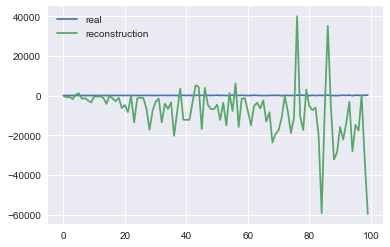

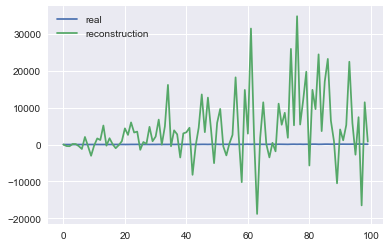

In [22]:
mus, sigmas = reconstruct(sess, x_train, vrnn, batch_size)
plot_reconstruction(mus, sigmas, x_train, 0)

In [ ]:
sess2 = get_new_session()
j=0
batch = x_data[j*batch_size:(j+1)*batch_size]
cell, hidden, priors = sess.run([vrnn.cell_states, vrnn.hidden_states, vrnn.priors], feed_dict={vrnn.x: batch})
cell = cell[0]
hidden = hidden[0]
priors = priors[0]
mu = priors[0]
sigma= priors[1]
print(mu.shape, mu)
print(sigma.shape, sigma)

In [ ]:
# TODO
# loop over learning rates
# relative is computational time
# wall time is actual time

# play with embedding. look at the inferred z for different sequences. write them somehow?